# Model-based Optimization

### An interactive, visual walkthrough

Optimization is a very rich field impacting countless applied, real-world problems. Chemical and materials R&D studies are one such class of problem; once the design space of a system is understood, adjusting parameters to find the global performance optimum can be treated as an optimization problem.

The problem with physical systems is that they are frequently very slow to evaluate, and they also produce noisy and unreliable responses. This requires an underlying algorithm that can accommodate *uncertainty* in its predictions - it must understand that it may have to sample the same condition multiple times to characterize the true response. The class of optimization algorithms that perform best in these circumstances are referred to as **model-based optimization algorithms**. In the case where the underlying model is a Gaussian Process Model, this is referred to as **Bayesian Optimization**.

So to summarize:
- slow experiments
- noisy output
- use model-based optimization algo

This notebook provides an interactive, visual tour of the inner-workings of simple model-based optimization algorithms.

In [1]:
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lolopy.learners import RandomForestRegressor, RegressionTreeLearner, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from scipy.stats import norm, truncnorm

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib widget
# plt.style.use({'font.size':16})
# sns.set_context('talk')

## We start with a Response Function

Every time we try to influence the world and observe the result, we are observing some true underlying **response function**. When I make fried dumplings, the observed response is the `Taste`: some metric of how satisfying the dumpling is upon consumption. The function that produced that result is probably something like:

$$ Taste = f(frying\:time, frying\:temperature, type\:of\:filling, quality\:of\:wrap) $$

In general, because the universe is complex, I have no idea what the true form of that response function is. All I can do is make a dumpling, observe its taste, adjust the parameters of my dumpling preparation, and hope for the best.

In [2]:
response = lambda x: -(np.sin(x-7)+np.sin(10/3*(x-7))+8)+15

In [3]:
def fplot(func, x):
    x_range = np.linspace(x.min()-0.5, x.max()+0.5, 1000)
    plt.plot(x_range, func(x_range), ':', linewidth=1.5, color='xkcd:indigo', alpha=0.5, label='True Response')

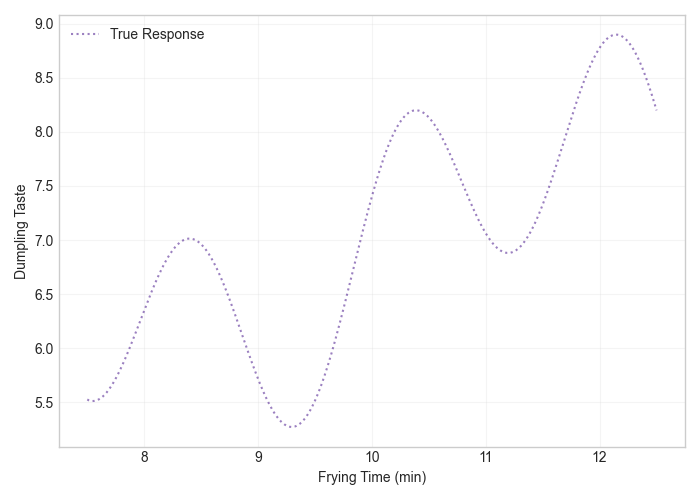

In [4]:
fig0, ax0 = plt.subplots(1,1, tight_layout=True, figsize=(7,5))
fplot(response, np.array([8,12]));
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste'); plt.grid(alpha=0.2);

### I might have some initial data

Let's say I've already made a few dumplings and observed their taste. To start with, I'm only going to experiment with *frying time*.

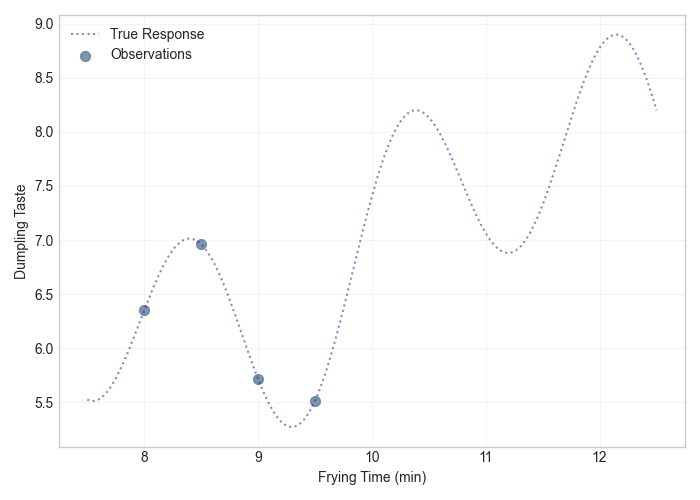

In [5]:
trials = np.array([8, 8.5, 9, 9.5])
observations = response(trials)

fig1, ax1 = plt.subplots(1,1, tight_layout=True, figsize=(7,5))
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste'); plt.grid(alpha=0.2);

## Optimization

If my goal is to maximize `Taste`, I am performing an optimization. Optimization is "the problem of finding the *best* solution from all feasible solutions". Here, let's define *best* to be "Taste as high as possible". A *solution* is a set of input parameters and their observed Taste.

The way in which I go about finding the best solution is called an **optimization algorithm**. An optimization algorithm really only needs two things:

- a method of selecting the next trial
- a stopping criteria

A perfectly acceptable algorithm for this problem would be: "increment frying time by 30 seconds until Taste is greater than 8".

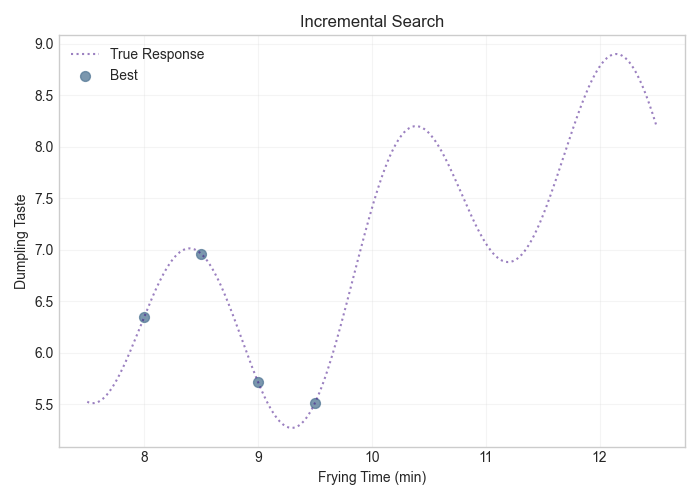

In [6]:
trials = np.array([8, 8.5, 9, 9.5])
observations = response(trials)

fig2, ax2 = plt.subplots(1,1, tight_layout=True, figsize=(7,5))
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Best')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste'); plt.grid(alpha=0.2); plt.title('Incremental Search');

### Re-run the cell below repeatedly (ctrl + Enter) to play out the search strategy

In [13]:
trials = np.append(trials, trials[-1]+0.5)
observations = np.append(observations, response(trials[-1]))
best = (trials[observations.argmax()], observations.max())

plt.sca(ax2); plt.cla();
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.scatter(x=best[0], y=best[1], s=200, marker='*', color='xkcd:magenta', alpha=1, label='Best')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste'); plt.grid(alpha=0.2); plt.title('Incremental Search');

## Random Search

Another perfectly acceptable algorithm is: "try random frying times until Taste is greater than 8"

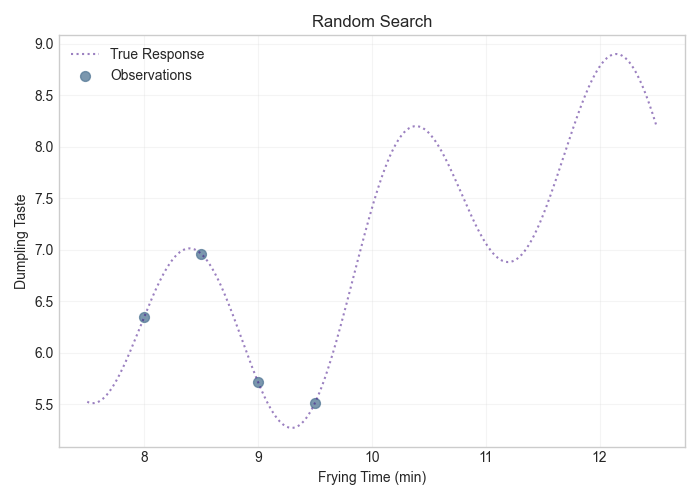

In [14]:
trials = np.array([8, 8.5, 9, 9.5])
observations = response(trials)

fig3, ax3 = plt.subplots(1,1, tight_layout=True, figsize=(7,5))
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste'); plt.grid(alpha=0.2); plt.title('Random Search');

### Re-run the cell below repeatedly (ctrl + Enter) to play out the search strategy

In [29]:
trials = np.append(trials, np.random.uniform(7.5,12.5))
observations = np.append(observations, response(trials[-1]))
best = (trials[observations.argmax()], observations.max())

plt.sca(ax3); plt.cla();
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.scatter(x=best[0], y=best[1], s=200, marker='*', color='xkcd:magenta', alpha=1, label='Best')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste'); plt.grid(alpha=0.2); plt.title('Random Search');

## The world is noisy

#### Input Noise
In the real world, we never make perfect observations - noise is everywhere. My dumpling wrapping technique may be inconsistent. My frying pan may not hold a steady temperature. I forgot to set a timer and don't actually know how long I fried my dumplings, so I just guess. These are all forms of **input noise**. In many cases, we're aware of the presence of input noise, but it is very difficult to measure. In fact, once we can measure a source of input noise, it becomes easier to control and ultimately eliminate (or leverage).

#### Measurement Noise
I am also an imperfect judge of dumpling Taste. Depending on my mood, the number of dumplings I've already eaten, or the time I allow them to sit, my judgment of the same dumpling's taste may vary. This is called **measurement noise**.

#### Output Noise
All of this noise shows up as **output noise** in my measurements of Taste. We denote that through the inclusion of a Greek $\epsilon$ in Taste response function:


$$ Taste = f(frying\:time, frying\:temperature, type\:of\:filling, quality\:of\:wrap)+\epsilon$$

### Noisy Optimization

All of this noise makes optimization *much harder*. When I can't trust the value of my output, it's hard to know when to stop. Our *Random Search* algorithm, for example, now looks a bit more random.

In [30]:
noisy_response = lambda x: response(x) + np.random.normal(0,0.3,size=x.shape)

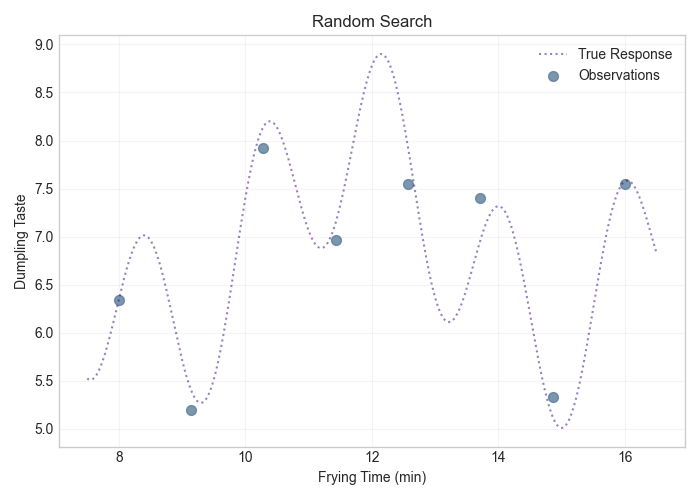

In [31]:
trials = np.linspace(8,16,8)
observations = noisy_response(trials)

fig4, ax4 = plt.subplots(1,1, tight_layout=True, figsize=(7,5))
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste'); plt.grid(alpha=0.2); plt.title('Random Search');

### Re-run the cell below repeatedly (ctrl + Enter) to play out the search strategy

In [42]:
trials = np.append(trials, np.random.uniform(8,16))
observations = np.append(observations, noisy_response(trials[-1]))
best = (trials[observations.argmax()], observations.max())

plt.sca(ax4); plt.cla();
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.scatter(x=best[0], y=best[1], s=200, marker='*', color='xkcd:magenta', alpha=1, label='Best')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste'); plt.grid(alpha=0.2); plt.title('Random Search');

## Models to the rescue

Models, in some sense, smooth out the noise in data. Rather than moving around incrementally or guessing randomly, I can make some assumption about how the universe works, and use that to guide the selection of subsequent trials.

This is called **model-based optimization**. In its simplest mode, the algorithm is:

- Select the next trial as the model's *best guess* of where the true optimum lies
- Iterate until the model stops changing

A very common assumption is that the universe behaves like a **parabola**. Parabolas look like a bowl, or a hill, and encode the assumption that "there be an optimum in these parts".

The update step (selection of the next trial) is more complicated than the previous one-liners, so we'd better make that its own function.

In [46]:
def next_trial_parabola(trials, observations, design_space=(8,16), degree=2):
    model = Pipeline([('features',PolynomialFeatures(degree=degree)),                    # Make model
                       ('scaler',StandardScaler()),
                       ('linear_model',LinearRegression())])
    model.fit(trials.reshape((-1,1)), observations.reshape((-1,1)))         # Train model
    enum_design_space = np.linspace(design_space[0],design_space[1],1000)   # Generate Design Space
    predicted_response = model.predict(enum_design_space.reshape((-1,1)))   # Predict on Design Space
    return enum_design_space[predicted_response.ravel().argmax()], model    # Return Best point and trained model

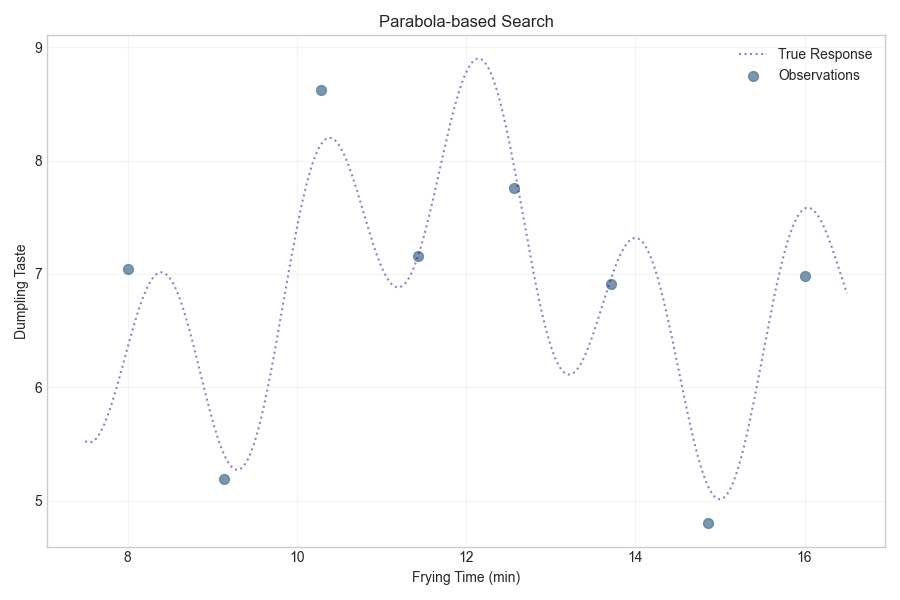

In [47]:
trials = np.linspace(8,16,8)
observations = noisy_response(trials)

fig5, ax5 = plt.subplots(1,1, tight_layout=True, figsize=(9,6))
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste');
plt.grid(alpha=0.2); plt.title('Parabola-based Search');

### Re-run the cell below repeatedly (ctrl + Enter) to play out the search strategy

In [59]:
next_trial, model = next_trial_parabola(trials, observations)
trials = np.append(trials, next_trial)
observations = np.append(observations, noisy_response(trials[-1]))
best = (trials[observations.argmax()], observations.max())

plt.sca(ax5); plt.cla();
x_model = np.linspace(trials.min(),trials.max(),1000);
y_model = model.predict(x_model.reshape((-1,1))).ravel()
model_best = (x_model[y_model.argmax()], y_model.max())
plt.plot(x_model, y_model, '--', linewidth=1.5, color='xkcd:salmon', alpha=0.8, label='Model');
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.scatter(x=model_best[0], y=model_best[1], s=200, marker='*', color='xkcd:salmon', alpha=0.8, label='Best Model Prediction (This Iteration)')
plt.scatter(x=trials[-1], y=observations[-1], s=75, color='xkcd:salmon', alpha=0.8, label='Observation (This Iteration)')
plt.scatter(x=best[0], y=best[1], s=200, marker='*', color='xkcd:magenta', alpha=1, label='Best Observation (All Iterations)')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste');
plt.grid(alpha=0.2); plt.title('Parabola-based Search');

## We could use any model here

The parabola is a three-parameter model, meaning that it is quite rigid. Fewer parameters means more interpretable, and less required data to get started, but notice that it was unable to adapt to the shape of the true underlying model.

### Enter `lolopy`

Lolopy is an implementation of what's called a `RandomForestRegressor`. RandomForest is highly adaptable, but needs at least 8 points to train. Let's give it some more finely-spaced dumpling trials.

In [60]:
def next_trial_lolo(trials, observations, design_space=(8,16)):
    model = RandomForestRegressor(bias_learner=RegressionTreeLearner(max_depth=3),
                                  randomize_pivot_location=True)
    model.fit(trials.reshape((-1,1)), observations.reshape((-1,1)))         # Train model
    enum_design_space = np.linspace(design_space[0],design_space[1],1000)   # Generate Design Space
    predicted_response = model.predict(enum_design_space.reshape((-1,1)))   # Predict on Design Space
    
    return enum_design_space[predicted_response.ravel().argmax()], model    # Return Best point and trained model

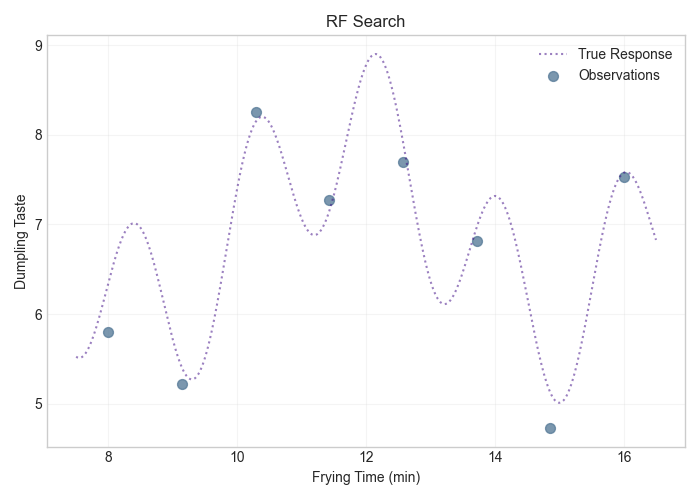

In [61]:
trials = np.linspace(8,16,8)
observations = noisy_response(trials)

fig6, ax6 = plt.subplots(1,1, tight_layout=True, figsize=(7,5))
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste');
plt.grid(alpha=0.2); plt.title('RF Search');

### Re-run the cell below repeatedly (ctrl + Enter) to play out the search strategy

In [76]:
next_trial, model = next_trial_lolo(trials, observations)
trials = np.append(trials, next_trial)
observations = np.append(observations, noisy_response(trials[-1]))
best = (trials[observations.argmax()], observations.max())

plt.sca(ax6); plt.cla();
x_model = np.linspace(trials.min(),trials.max(),1000);
y_model = model.predict(x_model.reshape((-1,1))).ravel()
model_best = (x_model[y_model.argmax()], y_model.max())
plt.plot(x_model, y_model, '--', linewidth=1.5, color='xkcd:salmon', alpha=0.8, label='Model');
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.scatter(x=model_best[0], y=model_best[1], s=200, marker='*', color='xkcd:salmon', alpha=0.8, label='Best Model Prediction (This Iteration)')
plt.scatter(x=trials[-1], y=observations[-1], s=75, color='xkcd:salmon', alpha=0.8, label='Observation (This Iteration)')
plt.scatter(x=best[0], y=best[1], s=200, marker='*', color='xkcd:magenta', alpha=1, label='Best Observation (All Iterations)')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste');
plt.grid(alpha=0.2); plt.title('RF Search');

## All models are wrong...

... But some are useful. RandomForest gives a better approximation of the True Response, but we're still making many observations in the same place. The problem is that we are assuming that our model is correct, and are trying to *exploit* it too soon. Our current update strategy was to pick the point the model thought was best. But if the model is uncertain? We need a way to take this into account.

#### Uncertainty estimates

An uncertainty estimate expresses the fact that **our model is probably wrong**. Lolopy is built not only to make preditions for new trials, but also to estimate *how wrong it might be* about those predictions.

Because of this, our model will no longer look like a solid line, but more of a shaded area. The wider the shaded area, the more uncertain the model is.

#### Acquisition Functions

Our update strategy should take these uncertainty estimates into account. Rather than selecting the frying time with the highest predicted Taste, we can select the frying time with the *highest likelihood of improving Taste*. **This is called an acquisition function**, and this particular acquisition function is called "Likelihood of Improvement". Code is also implemented below for "Expected Improvement", which seeks to maximize the expectation value of the model output, weighting upside uncertainty more strongly. Think of the difference between these as "how likely am I to see any improvement at all?" *vs.* "how much do I expect to improve?".

In [84]:
def next_trial_lolo_uq(trials, observations, design_space=(8,16)):
    model = RandomForestRegressor(
#         bias_learner=RegressionTreeLearner(max_depth=3),
#         randomize_pivot_location=True
    )
    model.fit(trials.reshape((-1,1)), observations.reshape((-1,1)))                   # Train model
    enum_design_space = np.linspace(design_space[0],design_space[1],100)              # Generate Design Space
    pred_response, pred_std = \
        model.predict(enum_design_space.reshape((-1,1)), return_std=True)             # Predict on Design Space with uncertainty
    scores = np.array(
        [truncnorm(observations.max(),np.inf,loc=mean,scale=std).expect(lambda x: x)
         for mean,std in zip(pred_response, pred_std)] # EI acquisition function
#         [1-norm(mean,std).cdf(observations.max()) for mean,std in zip(pred_response, pred_std)] # LI
    )
    return enum_design_space, pred_response, pred_std, scores                         # Return evaluated design space

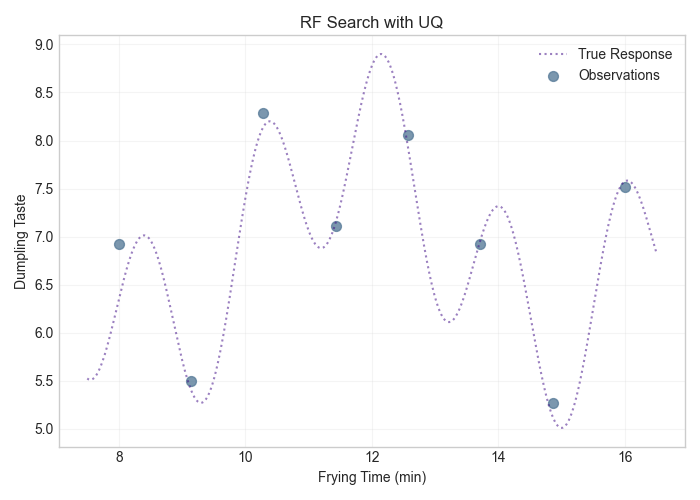

In [85]:
trials = np.linspace(8,16,8)
observations = noisy_response(trials)

fig7, ax7 = plt.subplots(1,1, tight_layout=True, figsize=(7,5))
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste');
plt.grid(alpha=0.2); plt.title('RF Search with UQ');

### Re-run the cell below repeatedly (ctrl + Enter) to play out the search strategy

In [113]:
design_space, pred_response, pred_std, scores = next_trial_lolo_uq(trials, observations)
next_trial = (design_space[scores.argmax()], pred_response[scores.argmax()])
trials = np.append(trials, next_trial[0])
observations = np.append(observations, noisy_response(trials[-1]))
best = (trials[observations.argmax()], observations.max())

plt.sca(ax7); plt.cla();
plt.plot(design_space, pred_response, '--', linewidth=1.5, color='xkcd:salmon', alpha=0.8, label='Model');
plt.fill_between(design_space, pred_response-pred_std, pred_response+pred_std, color='xkcd:salmon', alpha=0.2)
fplot(response, np.append(trials,12));
plt.scatter(x=trials, y=observations, s=50, color='xkcd:steel blue', alpha=0.8, label='Observations')
plt.scatter(x=next_trial[0], y=next_trial[1], s=250, marker='*', color='xkcd:salmon', alpha=1, label='Best Model Prediction (This Iteration)')
plt.axvline(x=trials[-1], ymin=pred_response[scores.argmax()]-pred_std[scores.argmax()], ymax=pred_response[scores.argmax()]+pred_std[scores.argmax()], color='xkcd:salmon', lw=1.5)
plt.scatter(x=trials[-1], y=observations[-1], s=75, color='xkcd:salmon', alpha=1, label='Observation (This Iteration)')
plt.scatter(x=best[0], y=best[1], s=250, marker='*', color='xkcd:magenta', alpha=1, label='Best Observation (All Iterations)')
plt.legend(); plt.xlabel('Frying Time (min)'); plt.ylabel('Dumpling Taste');
plt.grid(alpha=0.2); plt.title('RF Search with UQ');

## That's all

In principle, model-based optimization can be conducted with any model that provides prediction uncertainties as part of its outputs. GPMs are particularly popular in this space as well. Any model with `.fit()` and `.predict()` methods could be dropped into the code loop above.